#  MACHINE LEARNING: Portugal Wine. Multiple Linear Regression to model Quality using R and K fold cross-validation

By: Hector Alvaro Rojas | Data Science, Visualizations and Applied Statistics | November 17, 2017<br>
Url: [http://www.arqmain.net]   &nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;   GitHub: [https://github.com/arqmain]
<hr>

# I Introduction

This project develops Multiple Linear Regression machine learning model to predict the quality of the wine according to 12 variables that characterize the wine and its quality (score between 1 and 10). 

I use the famous Portugal wine dataset. Two datasets are available of which one dataset is about red wine and have 1599 different varieties and the other is on white wine and have 4898 varieties. I have combined them into one dataset named "wine" and created one additional variable "type" with its categories "1 (white)" and "2 (red)".

All wines are produced in a particular area of Portugal. Data are collected on 12 different properties of the wines one of which is Quality, based on sensory data. Quality is an ordinal variable with a possible ranking from 1 (worst) to 10 (best). Each variety of wine is tasted by three independent tasters and the final rank assigned is the median rank given by the tasters.

Even though the response variable -Quality- is ordinal, in this project it will be assumed to be a continuous variable which is possible to be predicted by the independent predictors, all of which are continuous.

The original data along with detailed description can be found here [ http://archive.ics.uci.edu/ml/datasets/Wine+Quality].

The columns of the "wine" dataset are the variables (features): fixed acidity; volatile acidity; citric acid; residual sugar; chlorides; free sulfur dioxide; total sulfur dioxide; density; pH; sulphates; alcohol; quality. The 13th column is the type of wine observed: white; red.

I consider the original dataset without the variables "density" and "free.sulfor.dioxide". I get rid of them because they could generate a problem of multicollinearity in the process of classification.

The final dataset (df) keep all the register of the original database but replace the upper outliers by its corresponding <i>Threshold</i>.

I consider outliers those points that have any predictor variable value to be outside of the limits constructed by box plots. The following rule is applied:

* A predictor value is considered to be an upper outlier only if it is greater than <b>Threshold = Q3 + 1.5IQR</b>

Application of this rule does not reduces the original datasize becouse it does not eliminate any register.  So, <i>df</i> data size is the same as the original (6497 registers).

The model performance is evaluated using R, K fold cross-validation, Rsquared and RMSE metrics. I consider 70% and 30% original dataset splitting for the training and testing datasets respectively.

# II Loading the Data

In [117]:
# first remove ALL objects and close all possible connections
closeAllConnections()
rm(list = ls(all = TRUE)) # Does remove all inclusive hidden

# see your memory size
memory.size() 

In [2]:
# install packages and load libraries
ipak <- function(pkg){
    new.pkg <- pkg[!(pkg %in% installed.packages()[, "Package"])]
    if (length(new.pkg)) 
        install.packages(new.pkg, dependencies = c("Depends", "Suggests"))
    sapply(pkg, require, character.only = TRUE)
}
# usage
packages <- c("plyr", "dplyr", "leaps", "MASS", "car", "caret")
ipak(packages)
  

Loading required package: plyr
Loading required package: dplyr

Attaching package: 'dplyr'

The following objects are masked from 'package:plyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: leaps
Warning message:
"package 'leaps' was built under R version 3.4.2"Loading required package: MASS

Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select

Loading required package: car
Warning message:
"package 'car' was built under R version 3.4.2"
Attaching package: 'car'

The following object is masked from 'package:dplyr':

    recode

Loading required package: caret
Loading required package: lattice
Loading required package: ggplot2


plyr dplyr leaps  MASS   car caret 
 TRUE  TRUE  TRUE  TRUE  TRUE  TRUE

In [3]:
# define path location of datasets
wine1.url <- "http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
wine2.url <- "http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

# read datasets
wine1 <- read.csv(wine1.url, header=TRUE, sep=';')
wine2 <- read.csv(wine2.url, header=TRUE, sep=';')

# create dataset base
wine <- rbind(cbind(wine1, type= 1), cbind(wine2, type= 0))

df= subset(wine, select=c('fixed.acidity', 'volatile.acidity', 'citric.acid', 'residual.sugar', 'chlorides' ,'total.sulfur.dioxide','pH', 'sulphates', 'alcohol', 'quality', 'type'))
attach(df)
head(df)
rm("wine", "wine1", "wine2")

# get some information about the dataset
str(df)


fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,total.sulfur.dioxide,pH,sulphates,alcohol,quality,type
7.0,0.27,0.36,20.7,0.045,170,3.00,0.45,8.8,6,1
6.3,0.30,0.34,1.6,0.049,132,3.30,0.49,9.5,6,1
8.1,0.28,0.40,6.9,0.050,97,3.26,0.44,10.1,6,1
7.2,0.23,0.32,8.5,0.058,186,3.19,0.40,9.9,6,1
7.2,0.23,0.32,8.5,0.058,186,3.19,0.40,9.9,6,1
8.1,0.28,0.40,6.9,0.050,97,3.26,0.44,10.1,6,1


'data.frame':	6497 obs. of  11 variables:
 $ fixed.acidity       : num  7 6.3 8.1 7.2 7.2 8.1 6.2 7 6.3 8.1 ...
 $ volatile.acidity    : num  0.27 0.3 0.28 0.23 0.23 0.28 0.32 0.27 0.3 0.22 ...
 $ citric.acid         : num  0.36 0.34 0.4 0.32 0.32 0.4 0.16 0.36 0.34 0.43 ...
 $ residual.sugar      : num  20.7 1.6 6.9 8.5 8.5 6.9 7 20.7 1.6 1.5 ...
 $ chlorides           : num  0.045 0.049 0.05 0.058 0.058 0.05 0.045 0.045 0.049 0.044 ...
 $ total.sulfur.dioxide: num  170 132 97 186 186 97 136 170 132 129 ...
 $ pH                  : num  3 3.3 3.26 3.19 3.19 3.26 3.18 3 3.3 3.22 ...
 $ sulphates           : num  0.45 0.49 0.44 0.4 0.4 0.44 0.47 0.45 0.49 0.45 ...
 $ alcohol             : num  8.8 9.5 10.1 9.9 9.9 10.1 9.6 8.8 9.5 11 ...
 $ quality             : int  6 6 6 6 6 6 6 6 6 6 ...
 $ type                : num  1 1 1 1 1 1 1 1 1 1 ...


In [4]:
# verify response variable "type" as factor
df$type <- as.factor(df$type)
df$quality <- as.numeric(df$quality)

In [5]:
# get some information about the dataset
str(df)

'data.frame':	6497 obs. of  11 variables:
 $ fixed.acidity       : num  7 6.3 8.1 7.2 7.2 8.1 6.2 7 6.3 8.1 ...
 $ volatile.acidity    : num  0.27 0.3 0.28 0.23 0.23 0.28 0.32 0.27 0.3 0.22 ...
 $ citric.acid         : num  0.36 0.34 0.4 0.32 0.32 0.4 0.16 0.36 0.34 0.43 ...
 $ residual.sugar      : num  20.7 1.6 6.9 8.5 8.5 6.9 7 20.7 1.6 1.5 ...
 $ chlorides           : num  0.045 0.049 0.05 0.058 0.058 0.05 0.045 0.045 0.049 0.044 ...
 $ total.sulfur.dioxide: num  170 132 97 186 186 97 136 170 132 129 ...
 $ pH                  : num  3 3.3 3.26 3.19 3.19 3.26 3.18 3 3.3 3.22 ...
 $ sulphates           : num  0.45 0.49 0.44 0.4 0.4 0.44 0.47 0.45 0.49 0.45 ...
 $ alcohol             : num  8.8 9.5 10.1 9.9 9.9 10.1 9.6 8.8 9.5 11 ...
 $ quality             : num  6 6 6 6 6 6 6 6 6 6 ...
 $ type                : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...


In [6]:
#summarize full dataset by columns 
propmiss <- function(dataframe) {
	m <- sapply(dataframe, function(x) {
		data.frame(
			n=length(!is.na(x)), 
			nmiss=sum(is.na(x)), 
			propmiss=sum(is.na(x))/length(x),
			P25=round(quantile(x, 0.25, na.rm=TRUE),2),
			P75=round(quantile(x, 0.75, na.rm=TRUE),2),            
			IQR=round(IQR(x, na.rm=TRUE),2),
			Threshold= round(quantile(x, 0.75, na.rm=TRUE),2) + 1.5*round(IQR(x, na.rm=TRUE),2),            
			Minimum=round(min(x, na.rm=TRUE),2),
			Median=round(median(x, na.rm=TRUE),2),            
			Maximum=round(max(x, na.rm=TRUE),2),
			Range=round(max(x, na.rm=TRUE)-min(x, na.rm=TRUE),2),
			Mean=round(mean(x, na.rm=TRUE),2),
			StDev=round(sd(x, na.rm=TRUE),2)
		)
	})
	d <- data.frame(t(m))
	d <- sapply(d, unlist)
	d <- as.data.frame(d)
	d$variable <- row.names(d)
	row.names(d) <- NULL
	d <- cbind(d[ncol(d)],d[-ncol(d)])
	return(d[order(d$propmiss), ])
}


In [7]:
# summarize original df dataset
(summary1=propmiss(df[,-c(10:11)])[,-(3:4)])


variable,n,P25,P75,IQR,Threshold,Minimum,Median,Maximum,Range,Mean,StDev
fixed.acidity,6497,6.40,7.70,1.30,9.650,3.80,7.00,15.90,12.10,7.22,1.30
volatile.acidity,6497,0.23,0.40,0.17,0.655,0.08,0.29,1.58,1.50,0.34,0.16
citric.acid,6497,0.25,0.39,0.14,0.600,0.00,0.31,1.66,1.66,0.32,0.15
residual.sugar,6497,1.80,8.10,6.30,17.550,0.60,3.00,65.80,65.20,5.44,4.76
chlorides,6497,0.04,0.06,0.03,0.105,0.01,0.05,0.61,0.60,0.06,0.04
total.sulfur.dioxide,6497,77.00,156.00,79.00,274.500,6.00,118.00,440.00,434.00,115.74,56.52
pH,6497,3.11,3.32,0.21,3.635,2.72,3.21,4.01,1.29,3.22,0.16
sulphates,6497,0.43,0.60,0.17,0.855,0.22,0.51,2.00,1.78,0.53,0.15
alcohol,6497,9.50,11.30,1.80,14.000,8.00,10.30,14.90,6.90,10.49,1.19


In [8]:
# r code to replace outliers by the threshold of each variable
library(mlr)

dfffull <- capLargeValues(df, target = "type",cols = c("fixed.acidity"),threshold = summary1[1,6])
dfffull <- capLargeValues(dfffull, target = "type",cols = c("volatile.acidity"),threshold = summary1[2,6])
dfffull <- capLargeValues(dfffull, target = "type",cols = c("citric.acid"),threshold = summary1[3,6])
dfffull <- capLargeValues(dfffull, target = "type",cols = c("residual.sugar"),threshold = summary1[4,6])
dfffull <- capLargeValues(dfffull, target = "type",cols = c("chlorides"),threshold = summary1[5,6])
dfffull <- capLargeValues(dfffull, target = "type",cols = c("total.sulfur.dioxide"),threshold = summary1[6,6])
dfffull <- capLargeValues(dfffull, target = "type",cols = c("pH"),threshold = summary1[7,6])
dfffull <- capLargeValues(dfffull, target = "type",cols = c("sulphates"),threshold = summary1[8,6])
dfffull <- capLargeValues(dfffull, target = "type",cols = c("alcohol"),threshold = summary1[9,6])
unloadNamespace("mlr")


Loading required package: ParamHelpers

Attaching package: 'mlr'

The following object is masked from 'package:caret':

    train



In [9]:
# get some information about the dataset
str(dfffull)


'data.frame':	6497 obs. of  11 variables:
 $ fixed.acidity       : num  7 6.3 8.1 7.2 7.2 8.1 6.2 7 6.3 8.1 ...
 $ volatile.acidity    : num  0.27 0.3 0.28 0.23 0.23 0.28 0.32 0.27 0.3 0.22 ...
 $ citric.acid         : num  0.36 0.34 0.4 0.32 0.32 0.4 0.16 0.36 0.34 0.43 ...
 $ residual.sugar      : num  17.5 1.6 6.9 8.5 8.5 ...
 $ chlorides           : num  0.045 0.049 0.05 0.058 0.058 0.05 0.045 0.045 0.049 0.044 ...
 $ total.sulfur.dioxide: num  170 132 97 186 186 97 136 170 132 129 ...
 $ pH                  : num  3 3.3 3.26 3.19 3.19 3.26 3.18 3 3.3 3.22 ...
 $ sulphates           : num  0.45 0.49 0.44 0.4 0.4 0.44 0.47 0.45 0.49 0.45 ...
 $ alcohol             : num  8.8 9.5 10.1 9.9 9.9 10.1 9.6 8.8 9.5 11 ...
 $ quality             : num  6 6 6 6 6 6 6 6 6 6 ...
 $ type                : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...


In [10]:
# remove and dettach df dataset
rm("df")
detach("df")

# rename dff dataset as df dataset to use the already created R scripts
df <- dfffull

# remove dff dataset
rm("dfffull")

In [11]:
str(df)

'data.frame':	6497 obs. of  11 variables:
 $ fixed.acidity       : num  7 6.3 8.1 7.2 7.2 8.1 6.2 7 6.3 8.1 ...
 $ volatile.acidity    : num  0.27 0.3 0.28 0.23 0.23 0.28 0.32 0.27 0.3 0.22 ...
 $ citric.acid         : num  0.36 0.34 0.4 0.32 0.32 0.4 0.16 0.36 0.34 0.43 ...
 $ residual.sugar      : num  17.5 1.6 6.9 8.5 8.5 ...
 $ chlorides           : num  0.045 0.049 0.05 0.058 0.058 0.05 0.045 0.045 0.049 0.044 ...
 $ total.sulfur.dioxide: num  170 132 97 186 186 97 136 170 132 129 ...
 $ pH                  : num  3 3.3 3.26 3.19 3.19 3.26 3.18 3 3.3 3.22 ...
 $ sulphates           : num  0.45 0.49 0.44 0.4 0.4 0.44 0.47 0.45 0.49 0.45 ...
 $ alcohol             : num  8.8 9.5 10.1 9.9 9.9 10.1 9.6 8.8 9.5 11 ...
 $ quality             : num  6 6 6 6 6 6 6 6 6 6 ...
 $ type                : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...


# III Getting train and test datasets

In [12]:
#stratified sampling to get the train and test dataset
set.seed(7) # Set Seed so that same sample can be reproduced in future also
# considering response variable as strata
data_part <- createDataPartition(y = df$quality  ,  p = 0.70, list = F)
dftest <- df[-data_part,] # 30% data goes here
dftrain <- df[data_part,] # 70% here


In [13]:
# get some information about training dataset
str(dftrain[,1:11])

'data.frame':	4549 obs. of  11 variables:
 $ fixed.acidity       : num  6.3 7.2 8.1 6.2 7 6.3 8.1 7.9 8.3 6.6 ...
 $ volatile.acidity    : num  0.3 0.23 0.28 0.32 0.27 0.3 0.22 0.18 0.42 0.17 ...
 $ citric.acid         : num  0.34 0.32 0.4 0.16 0.36 0.34 0.43 0.37 0.6 0.38 ...
 $ residual.sugar      : num  1.6 8.5 6.9 7 17.5 ...
 $ chlorides           : num  0.049 0.058 0.05 0.045 0.045 0.049 0.044 0.04 0.04 0.032 ...
 $ total.sulfur.dioxide: num  132 186 97 136 170 132 129 75 172 112 ...
 $ pH                  : num  3.3 3.19 3.26 3.18 3 3.3 3.22 3.18 2.98 3.25 ...
 $ sulphates           : num  0.49 0.4 0.44 0.47 0.45 0.49 0.45 0.63 0.67 0.55 ...
 $ alcohol             : num  9.5 9.9 10.1 9.6 8.8 9.5 11 10.8 9.7 11.4 ...
 $ quality             : num  6 6 6 6 6 6 6 5 5 7 ...
 $ type                : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...


In [14]:
# get some information about testing dataset
str(dftest[,1:11])

'data.frame':	1948 obs. of  11 variables:
 $ fixed.acidity       : num  7 8.1 7.2 8.1 8.6 6.6 6.2 6.5 6.5 7 ...
 $ volatile.acidity    : num  0.27 0.28 0.23 0.27 0.23 0.16 0.655 0.31 0.39 0.33 ...
 $ citric.acid         : num  0.36 0.4 0.32 0.41 0.4 0.4 0.48 0.14 0.23 0.32 ...
 $ residual.sugar      : num  17.55 6.9 8.5 1.45 4.2 ...
 $ chlorides           : num  0.045 0.05 0.058 0.033 0.035 0.044 0.029 0.044 0.051 0.053 ...
 $ total.sulfur.dioxide: num  170 97 186 63 109 143 75 133 149 138 ...
 $ pH                  : num  3 3.26 3.19 2.99 3.14 3.54 3.33 3.22 3.24 3.13 ...
 $ sulphates           : num  0.45 0.44 0.4 0.56 0.53 0.52 0.39 0.5 0.35 0.28 ...
 $ alcohol             : num  8.8 10.1 9.9 12 9.7 12.4 12.8 9.5 10 11.2 ...
 $ quality             : num  6 6 6 5 5 7 8 5 5 6 ...
 $ type                : Factor w/ 2 levels "0","1": 2 2 2 2 2 2 2 2 2 2 ...


In [24]:
# summarize training dataset
(summary=propmiss(dftrain[,-11])[,-(3:4)][,-6])

variable,n,P25,P75,IQR,Minimum,Median,Maximum,Range,Mean,StDev
fixed.acidity,4549,6.40,7.70,1.30,3.80,7.00,9.65,5.85,7.15,1.07
volatile.acidity,4549,0.23,0.41,0.18,0.08,0.29,0.66,0.58,0.33,0.15
citric.acid,4549,0.25,0.39,0.14,0.00,0.31,0.60,0.60,0.31,0.13
residual.sugar,4549,1.80,8.10,6.30,0.60,3.00,17.55,16.95,5.39,4.59
chlorides,4549,0.04,0.07,0.03,0.01,0.05,0.10,0.09,0.05,0.02
total.sulfur.dioxide,4549,78.00,156.00,78.00,6.00,118.00,274.50,268.50,115.58,56.52
pH,4549,3.11,3.32,0.21,2.72,3.21,3.63,0.91,3.22,0.16
sulphates,4549,0.43,0.60,0.17,0.22,0.51,0.86,0.64,0.53,0.13
alcohol,4549,9.50,11.30,1.80,8.00,10.30,14.00,6.00,10.49,1.19
quality,4549,5.00,6.00,1.00,3.00,6.00,9.00,6.00,5.82,0.87


In [25]:
# summarize testing dataset
(summary=propmiss(dftest[,-11])[,-(3:4)][,-6])

variable,n,P25,P75,IQR,Minimum,Median,Maximum,Range,Mean,StDev
fixed.acidity,1948,6.40,7.70,1.30,4.40,7.00,9.65,5.25,7.12,1.06
volatile.acidity,1948,0.23,0.40,0.17,0.10,0.29,0.66,0.56,0.33,0.14
citric.acid,1948,0.24,0.39,0.15,0.00,0.31,0.60,0.60,0.32,0.13
residual.sugar,1948,1.80,8.03,6.23,0.70,3.10,17.55,16.85,5.46,4.66
chlorides,1948,0.04,0.06,0.03,0.01,0.05,0.10,0.10,0.05,0.02
total.sulfur.dioxide,1948,77.00,156.00,79.00,8.00,119.00,274.50,266.50,115.90,55.66
pH,1948,3.11,3.33,0.22,2.79,3.21,3.63,0.84,3.22,0.16
sulphates,1948,0.43,0.60,0.17,0.26,0.50,0.86,0.60,0.53,0.13
alcohol,1948,9.50,11.40,1.90,8.40,10.30,14.00,5.60,10.49,1.21
quality,1948,5.00,6.00,1.00,3.00,6.00,9.00,6.00,5.82,0.88


# IV Multiple Linear Regression Model (MLR)
 
In this project I have considered Logistic Regression algorithm. I use "set.seed(7)" so that same sample can be reproduced in the future and also it ensures the results are directly comparable.

## 41 Find model equation

In [15]:
## full model
names(dftrain)
model1<- lm(quality ~ . , data=dftrain) 
(gs1<-summary(model1))
(extractAIC(model1))

[1] "fixed.acidity"        "volatile.acidity"     "citric.acid"         
 [4] "residual.sugar"       "chlorides"            "total.sulfur.dioxide"
 [7] "pH"                   "sulphates"            "alcohol"             
[10] "quality"              "type"


Call:
lm(formula = quality ~ ., data = dftrain)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.3454 -0.4693 -0.0418  0.4638  2.7182 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           3.0031080  0.3907816   7.685 1.86e-14 ***
fixed.acidity        -0.0331049  0.0145843  -2.270 0.023260 *  
volatile.acidity     -1.7665081  0.1124105 -15.715  < 2e-16 ***
citric.acid          -0.0185985  0.1031963  -0.180 0.856984    
residual.sugar        0.0216989  0.0029298   7.406 1.54e-13 ***
chlorides            -3.0396815  0.8364584  -3.634 0.000282 ***
total.sulfur.dioxide -0.0001446  0.0003191  -0.453 0.650579    
pH                    0.0231046  0.0876684   0.264 0.792143    
sulphates             0.6627954  0.1001858   6.616 4.13e-11 ***
alcohol               0.3347520  0.0115946  28.871  < 2e-16 ***
type1                -0.3026701  0.0622462  -4.862 1.20e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residu

[1]    11.000 -2763.826

In [16]:
# VIF variable inflation factor for each variable in the model
vif(model1)

fixed.acidity     volatile.acidity          citric.acid 
            2.039834             2.245922             1.617839 
      residual.sugar            chlorides total.sulfur.dioxide 
            1.515066             2.685009             2.722549 
                  pH            sulphates              alcohol 
            1.604042             1.435853             1.580880 
                type 
            6.074087

VIF >= 10 ==> variable is collinear and should be omitted from the model. 

So,  VIF < 10 for all variables ==> variables are ok and should be kept on the model. 

In [15]:
## stepwise Backward AIC model
names(dftrain)
model2<- step(lm(quality ~ ., data=dftrain), trace= F, direction = "backward", k=2) # Selección Backward usando criterio AIC
(gs2<-summary(model2))
extractAIC(model2)


[1] "fixed.acidity"        "volatile.acidity"     "citric.acid"         
 [4] "residual.sugar"       "chlorides"            "total.sulfur.dioxide"
 [7] "pH"                   "sulphates"            "alcohol"             
[10] "quality"              "type"


Call:
lm(formula = quality ~ fixed.acidity + volatile.acidity + residual.sugar + 
    chlorides + sulphates + alcohol + type, data = dftrain)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.3318 -0.4701 -0.0387  0.4616  2.7133 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       3.084980   0.199415  15.470  < 2e-16 ***
fixed.acidity    -0.035932   0.011889  -3.022 0.002523 ** 
volatile.acidity -1.762867   0.104134 -16.929  < 2e-16 ***
residual.sugar    0.021196   0.002788   7.602 3.51e-14 ***
chlorides        -3.092710   0.829334  -3.729 0.000194 ***
sulphates         0.658745   0.097754   6.739 1.80e-11 ***
alcohol           0.335905   0.011082  30.310  < 2e-16 ***
type1            -0.323370   0.049547  -6.526 7.47e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.7369 on 4541 degrees of freedom
Multiple R-squared:  0.2859,	Adjusted R-squared:  0.2848 
F-statistic: 259.7 on 7 and 4541

[1]     8.000 -2769.502

In [16]:
# VIF variable inflation factor for each variable in the model
vif(model2)

fixed.acidity volatile.acidity   residual.sugar        chlorides 
        1.356373         1.928524         1.372888         2.641023 
       sulphates          alcohol             type 
        1.367800         1.445170         3.850809

VIF >= 10 ==> variable is collinear and should be omitted from the model. 

So,  VIF < 10 for all variables ==> variables are ok and should be kept on the model. 

In [17]:
## stepwise Backward BIC model
names(dftrain)
model3<- step(lm(quality ~ ., data=dftrain), trace= F, direction = "backward", k=log(nrow(dftrain))) # Selección Backward usando criterio AIC
(gs3<-summary(model3))
extractAIC(model3)


[1] "fixed.acidity"        "volatile.acidity"     "citric.acid"         
 [4] "residual.sugar"       "chlorides"            "total.sulfur.dioxide"
 [7] "pH"                   "sulphates"            "alcohol"             
[10] "quality"              "type"


Call:
lm(formula = quality ~ fixed.acidity + volatile.acidity + residual.sugar + 
    chlorides + sulphates + alcohol + type, data = dftrain)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.3318 -0.4701 -0.0387  0.4616  2.7133 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       3.084980   0.199415  15.470  < 2e-16 ***
fixed.acidity    -0.035932   0.011889  -3.022 0.002523 ** 
volatile.acidity -1.762867   0.104134 -16.929  < 2e-16 ***
residual.sugar    0.021196   0.002788   7.602 3.51e-14 ***
chlorides        -3.092710   0.829334  -3.729 0.000194 ***
sulphates         0.658745   0.097754   6.739 1.80e-11 ***
alcohol           0.335905   0.011082  30.310  < 2e-16 ***
type1            -0.323370   0.049547  -6.526 7.47e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.7369 on 4541 degrees of freedom
Multiple R-squared:  0.2859,	Adjusted R-squared:  0.2848 
F-statistic: 259.7 on 7 and 4541

[1]     8.000 -2769.502

In [18]:
# VIF variable inflation factor for each variable in the model
vif(model3)

fixed.acidity volatile.acidity   residual.sugar        chlorides 
        1.356373         1.928524         1.372888         2.641023 
       sulphates          alcohol             type 
        1.367800         1.445170         3.850809

VIF >= 10 ==> variable is collinear and should be omitted from the model. 

So,  VIF < 10 for all variables ==> variables are ok and should be kept on the model. 

In [19]:
# All Subsets Regression library(leaps)

In [20]:
leaps<-regsubsets(quality ~ ., data=dftrain, nbest=2)

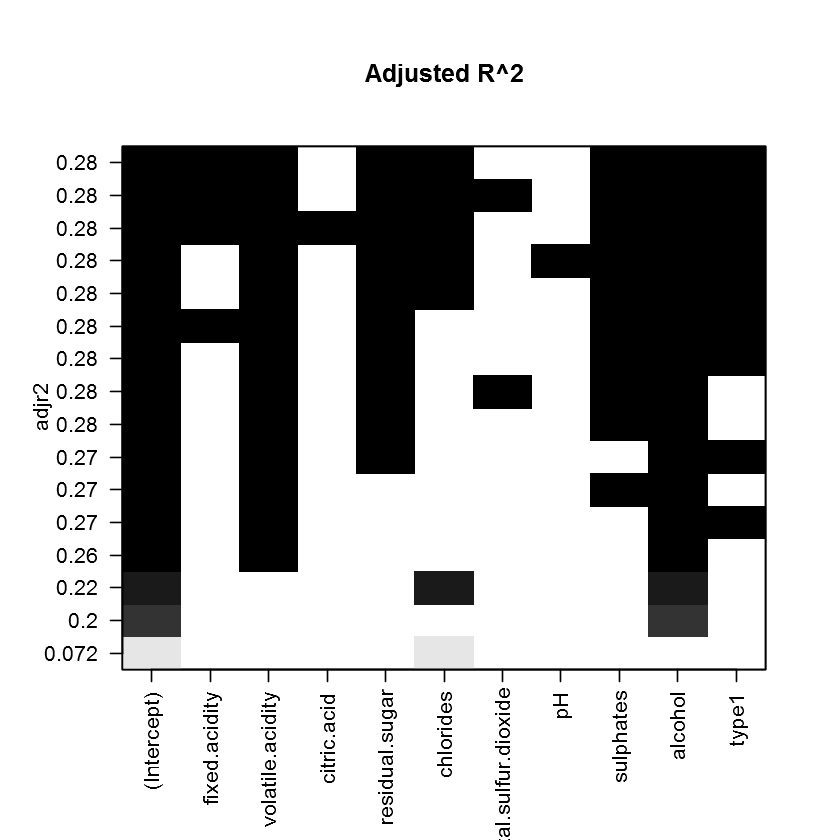

In [21]:
# library(leaps) "adjr2"
plot(leaps, scale="adjr2", main = "Adjusted R^2")

By adjusted \( R^2 \), the best model includes fixed.acidity, volatile.acidity, residual.sugar, chlorides, sulphates, alcohol, and type (variables that have black boxes at the higest Y-axis (adjr2) value).

In [22]:
# model4  leaps, plot "adjr2"
names(dftrain[-c(3, 6, 7)])
model4<- lm(quality ~ ., data=dftrain[-c(3, 6, 7)])
(gs4<-summary(model4))
extractAIC(model4)


[1] "fixed.acidity"    "volatile.acidity" "residual.sugar"   "chlorides"       
[5] "sulphates"        "alcohol"          "quality"          "type"


Call:
lm(formula = quality ~ ., data = dftrain[-c(3, 6, 7)])

Residuals:
    Min      1Q  Median      3Q     Max 
-3.3318 -0.4701 -0.0387  0.4616  2.7133 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       3.084980   0.199415  15.470  < 2e-16 ***
fixed.acidity    -0.035932   0.011889  -3.022 0.002523 ** 
volatile.acidity -1.762867   0.104134 -16.929  < 2e-16 ***
residual.sugar    0.021196   0.002788   7.602 3.51e-14 ***
chlorides        -3.092710   0.829334  -3.729 0.000194 ***
sulphates         0.658745   0.097754   6.739 1.80e-11 ***
alcohol           0.335905   0.011082  30.310  < 2e-16 ***
type1            -0.323370   0.049547  -6.526 7.47e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.7369 on 4541 degrees of freedom
Multiple R-squared:  0.2859,	Adjusted R-squared:  0.2848 
F-statistic: 259.7 on 7 and 4541 DF,  p-value: < 2.2e-16


[1]     8.000 -2769.502

In [23]:
# VIF variable inflation factor for each variable in the model
vif(model4)

fixed.acidity volatile.acidity   residual.sugar        chlorides 
        1.356373         1.928524         1.372888         2.641023 
       sulphates          alcohol             type 
        1.367800         1.445170         3.850809

VIF >= 10 ==> variable is collinear and should be omitted from the model. 

So,  VIF < 10 for all variables ==> variables are ok and should be kept on the model. 

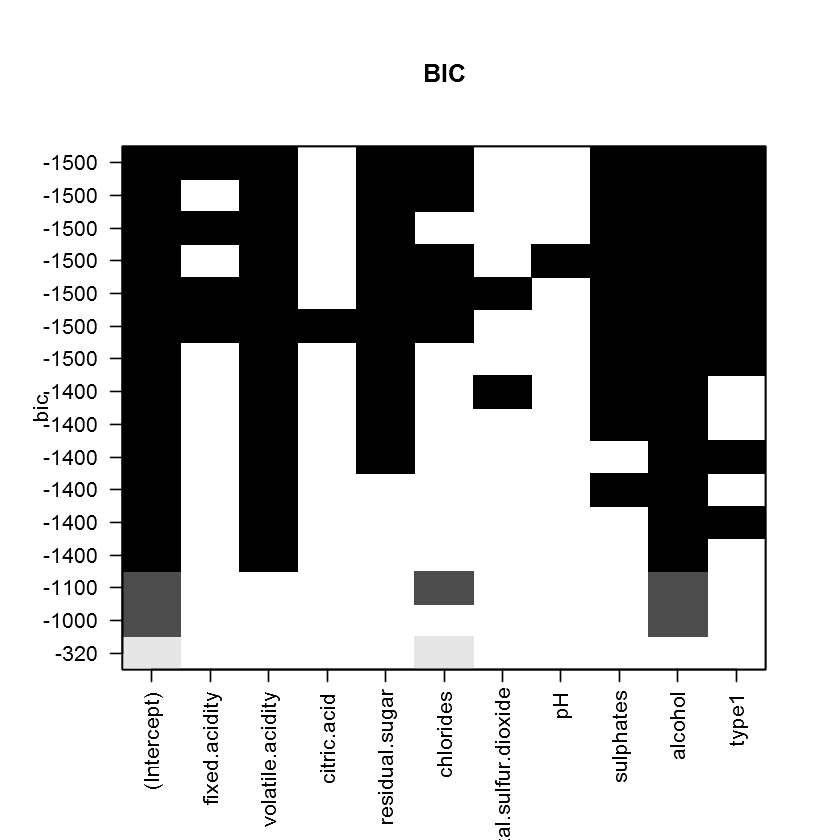

In [24]:
# library(leaps) "bic"
plot(leaps, scale="bic", main = "BIC")

By adjusted \( BIC\), the best model includes fixed.acidity, volatile.acidity, residual.sugar, chlorides, sulphates, alcohol, and type (variables that have black boxes at the higest Y-axis (adjr2) value).

In [25]:
# model5  leaps, plot "bic"
names(dftrain[-c(3, 6, 7)])
model5<- lm(quality ~ ., data=dftrain[-c(3, 6, 7)])
(gs5<-summary(model5))
extractAIC(model5)

[1] "fixed.acidity"    "volatile.acidity" "residual.sugar"   "chlorides"       
[5] "sulphates"        "alcohol"          "quality"          "type"


Call:
lm(formula = quality ~ ., data = dftrain[-c(3, 6, 7)])

Residuals:
    Min      1Q  Median      3Q     Max 
-3.3318 -0.4701 -0.0387  0.4616  2.7133 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       3.084980   0.199415  15.470  < 2e-16 ***
fixed.acidity    -0.035932   0.011889  -3.022 0.002523 ** 
volatile.acidity -1.762867   0.104134 -16.929  < 2e-16 ***
residual.sugar    0.021196   0.002788   7.602 3.51e-14 ***
chlorides        -3.092710   0.829334  -3.729 0.000194 ***
sulphates         0.658745   0.097754   6.739 1.80e-11 ***
alcohol           0.335905   0.011082  30.310  < 2e-16 ***
type1            -0.323370   0.049547  -6.526 7.47e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.7369 on 4541 degrees of freedom
Multiple R-squared:  0.2859,	Adjusted R-squared:  0.2848 
F-statistic: 259.7 on 7 and 4541 DF,  p-value: < 2.2e-16


[1]     8.000 -2769.502

In [26]:
# VIF variable inflation factor for each variable in the model
vif(model5)

fixed.acidity volatile.acidity   residual.sugar        chlorides 
        1.356373         1.928524         1.372888         2.641023 
       sulphates          alcohol             type 
        1.367800         1.445170         3.850809

In [27]:
VIF >= 10 ==> variable is collinear and should be omitted from the model. 

So,  VIF < 10 for all variables ==> variables are ok and should be kept on the model

ERROR: Error in parse(text = x, srcfile = src): <text>:1:11: unexpected '=='
1: VIF >= 10 ==
              ^


Model2, model4, and model5 are the same.  At the same time, model2 has achieved a lower AIC value (model2-AIC= -2769.50210955801) being the best model according to with this metric.  Also, we can compare the models using the ANOVA test. Let's say our null hypothesis is that second model is better than the first model. p < 0.05 would reject our hypothesis and in case p > 0.05, we'll fail to reject the null hypothesis.

In [28]:
#compare the models by using anova-chisq
anova(model1,model2,test = "Chisq")
anova(model1,model3,test = "Chisq")
anova(model2,model3,test = "Chisq")

Res.Df,RSS,Df,Sum of Sq,Pr(>Chi)
4538,2465.768,NA,NA,NA
4541,2465.944,-3,-0.1757344,0.955565


Res.Df,RSS,Df,Sum of Sq,Pr(>Chi)
4538,2465.768,NA,NA,NA
4541,2465.944,-3,-0.1757344,0.955565


Res.Df,RSS,Df,Sum of Sq,Pr(>Chi)
4541,2465.944,NA,NA,NA
4541,2465.944,0,0,NA


In [59]:
#compare the models by using lrtest-chisq
library(lmtest)
lrtest(model1, model2)
lrtest(model1, model3)
lrtest(model2,model3)

Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



#Df,LogLik,Df,Chisq,Pr(>Chisq)
12,-5061.838,NA,NA,NA
9,-5062.000,-3,0.3241941,0.9554158


#Df,LogLik,Df,Chisq,Pr(>Chisq)
12,-5061.838,NA,NA,NA
9,-5062.000,-3,0.3241941,0.9554158


#Df,LogLik,Df,Chisq,Pr(>Chisq)
9,-5062,NA,NA,NA
9,-5062,0,0,1


With p > 0.05, both test (ANOVA and LRTEST) also corroborates the fact that the second model (model2) is the best model according to the Stepwise method.  So, we will keep model2 and we will evaluate its performance as a supervised machine learning model.  

## 42 Model Diagnostics

Once the multiple linear regression model has been obtained, it must be verified if it complies with the basic assumptions defined a priori in its construction and that guarantee its predictive validity.

* Normality: The residual values should be normally distributed.
* Constant variance(homoscedasticity): Residuals shoud be uniformly distributed around "0".
* Independence: Residuals shoud be uniformly distributed around "0" without any tendency and independent of each other.
* Multicolinearity: It should be little or no correlation between predictor variables.
* Linearity: It should not be  be systematic relationship between the residual and the predicted values.
* Influencial Observations: It should not be observations that could influence the parameter estimation.

Given the low quality of fit of our model, only the diagnosis of normality, homocedasticity, multicollinearity and Influential Observations is made. In practical terms, there is no sign of a substantial improvement that could come from a more complete study of compliance with the basic assumptions. It is left to the reader's discretion to perform the diagnostic analyzes in full and make the changes in the model if appropriate. 

In [17]:
#selected model
model <- lm(quality ~ fixed.acidity + volatile.acidity + residual.sugar + chlorides + sulphates + alcohol + type, data = dftrain)
summary(model)


Call:
lm(formula = quality ~ fixed.acidity + volatile.acidity + residual.sugar + 
    chlorides + sulphates + alcohol + type, data = dftrain)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.3318 -0.4701 -0.0387  0.4616  2.7133 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       3.084980   0.199415  15.470  < 2e-16 ***
fixed.acidity    -0.035932   0.011889  -3.022 0.002523 ** 
volatile.acidity -1.762867   0.104134 -16.929  < 2e-16 ***
residual.sugar    0.021196   0.002788   7.602 3.51e-14 ***
chlorides        -3.092710   0.829334  -3.729 0.000194 ***
sulphates         0.658745   0.097754   6.739 1.80e-11 ***
alcohol           0.335905   0.011082  30.310  < 2e-16 ***
type1            -0.323370   0.049547  -6.526 7.47e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.7369 on 4541 degrees of freedom
Multiple R-squared:  0.2859,	Adjusted R-squared:  0.2848 
F-statistic: 259.7 on 7 and 4541

## How about Normality?

We will check this requirement by having a graphical appreciation of the distribution of the model's residuals and applying some usual statistical hypothesis tests to probe normality.

Whatever can happen from now on we have to remember that <i>"it is always better to test normality distribution on our model's residuals, than never test  normality at all"</i>.

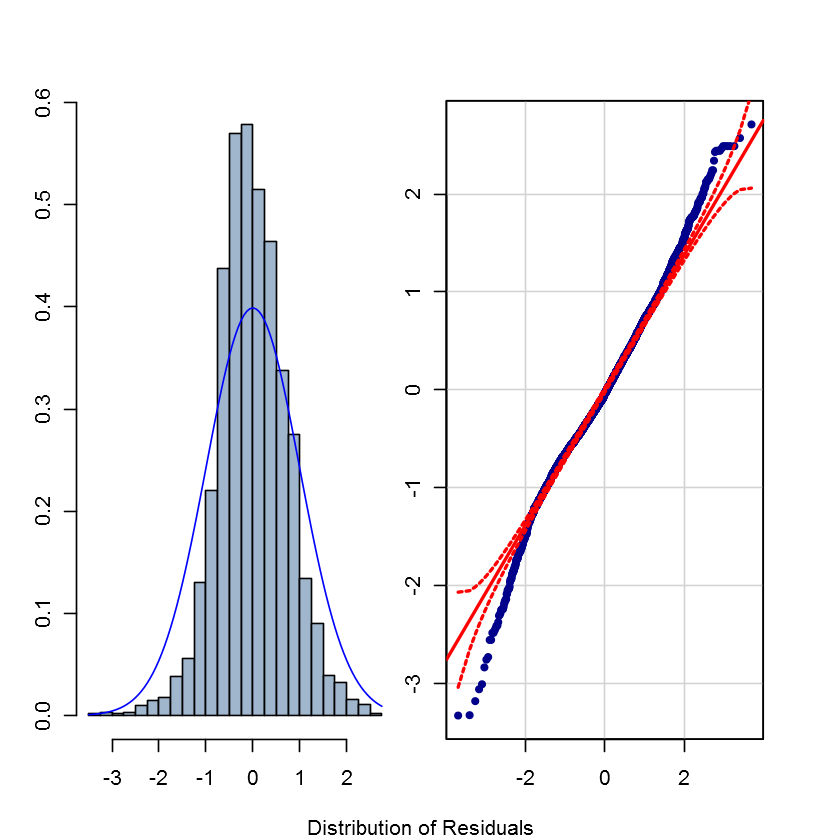

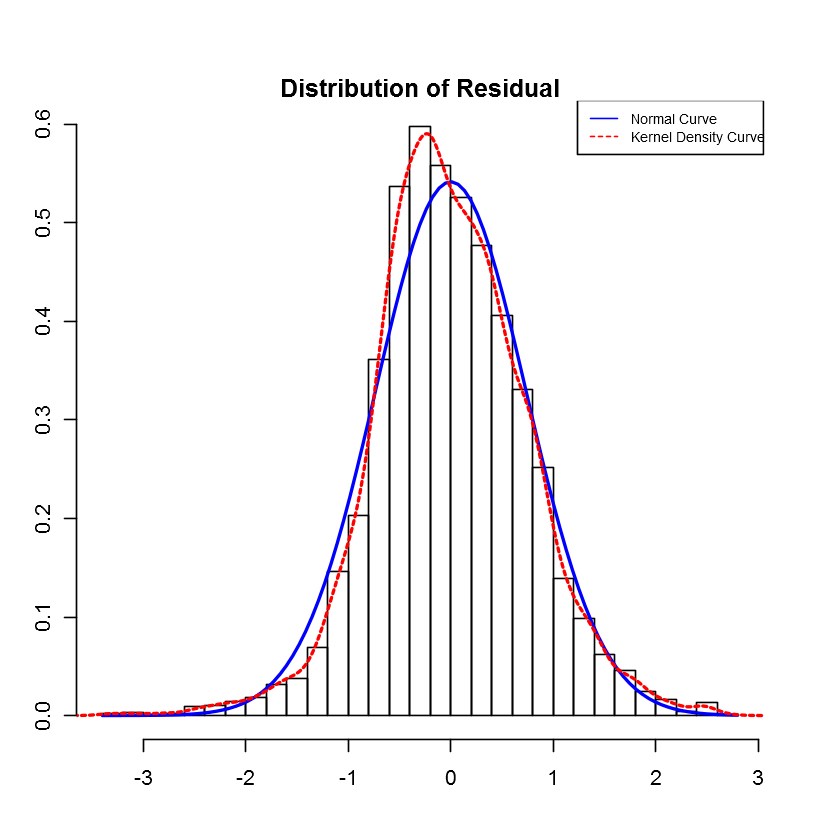

In [30]:
#Graphic appraisal
par(mfrow=c(1,2), oma = c(3,2,3,2) + 0.1, mar = c(1,1,1,1) + 0.1)
truehist(residuals(model), h = 0.25, col="slategray3")
curve(dnorm, add = TRUE, col="blue") # Agrega curva normal
qqPlot(residuals(model), pch=19, col="darkblue", cex=0.6)
mtext("Distribution of Residuals", outer=T, side=1, line = 2)
par(mfrow=c(1,1))
#Ploting residual plot as histogram
res= residuals(model)
hist(res, breaks=30, freq=FALSE, xlab="Residuals", main="Distribution of Residual", ylim=c(0,0.6))
curve(dnorm(x, mean=mean(res), sd=sd(res)), add=TRUE, col= "blue", lwd=2)
lines(density(res)$x, density(res)$y, col= "red", lwd=2, lty=2)
legend("topright", legend=c("Normal Curve", "Kernel Density Curve"), lty=1:2, col=c("blue","red"), cex=.7)


Residuals have an approximately symmetric distribution but there are outliers at both ends and some kid of small asymmetry to small residual values.  At the same time, as it is shown in the Q-Q plot, some values are out of the confidence bounds and far from the central line.

In [31]:
#Appreciation with statistical hypothesis test
# Ho: The sample comes from a normal distribution.
library(normtest)

###Prueba de Jarque-Bera
jb.norm.test(residuals(model))

library(nortest)

###Prueba de Anderson-Darling
ad.test(residuals(model))

###Cramer-von Mises test for normality
cvm.test(residuals(model))


	Jarque-Bera test for normality

data:  residuals(model)
JB = 160.57, p-value < 2.2e-16



	Anderson-Darling normality test

data:  residuals(model)
A = 8.0335, p-value < 2.2e-16


Warning message in cvm.test(residuals(model)):
"p-value is smaller than 7.37e-10, cannot be computed more accurately"


	Cramer-von Mises normality test

data:  residuals(model)
W = 1.1931, p-value = 7.37e-10


All the tests reject the hypothesis of normality. That is, the residuals of the model should not be statistically considered as "normal".

Because mlr models are robust by construction, they are able to support very well small deviations from the normal assumption.  Anyway, it is always better to be in presence of normality especially if we want to use the model to performance inferential predictions. 

<i><u>What to do now</u>?</i>

See what happens with outliers. How is the variance behavior? How about the linear relationship between the predictors with the dependent variable? Is there the presence of influential observations? 

If we are in the presence of these anomalies and make the respective corrections, this may improve normality. Otherwise, it would be necessary to study some transformation of the dependent variable and see what happens.

In general, transformation of the response variable may help if normality assumption is violated. The
function <i><b>powerTransform()</b></i> from <i><b>car</b></i> package can be used to estimate the transformation power of the
response variable.

## How about Multicollinearity?


Multicollinearity between variables is verified based on Variance Inflation Factor VIF).

We already checked this supposition by the time we were selecting the model.  Anyway, here it goes again.


In [41]:
# VIF variable inflation factor for each variable in the model
vif(model)

fixed.acidity volatile.acidity   residual.sugar        chlorides 
        1.356373         1.928524         1.372888         2.641023 
       sulphates          alcohol             type 
        1.367800         1.445170         3.850809


VIF >= 10 ==> variable is collinear and should be omitted from the model. 

So, in our case VIF < 10 for all variables ==> variables are ok and should be kept on the model


## How about Homoscedasticity (constant residual variation)?


We will check the homoscedasticity requirement by having a graphical appreciation of the distribution of the model's residuals and applying some usual tests of hypothesis to check its statistical ratification.


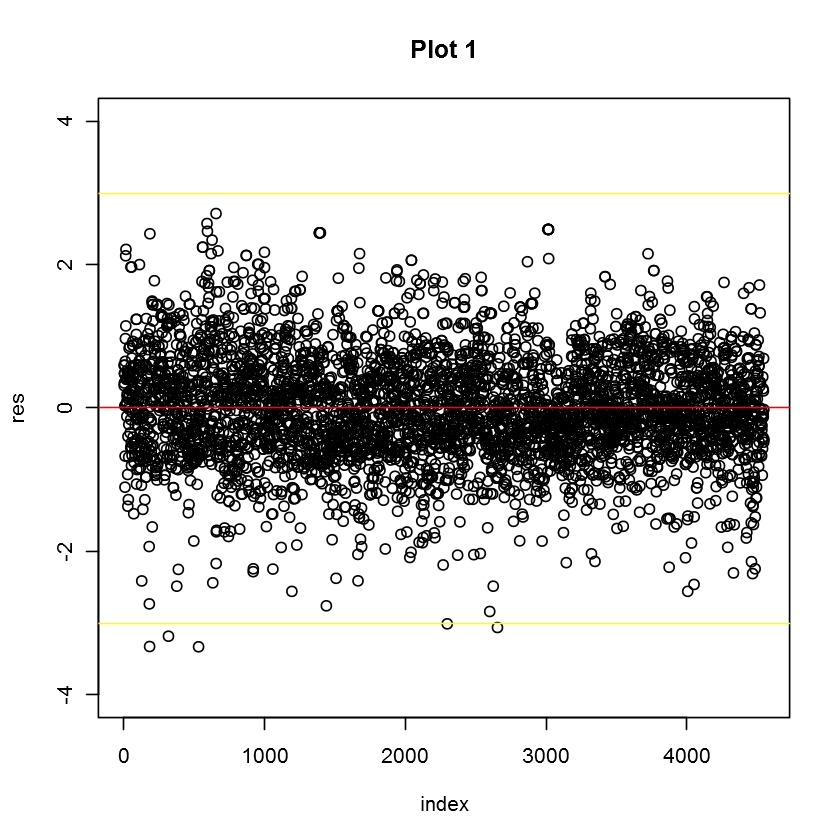

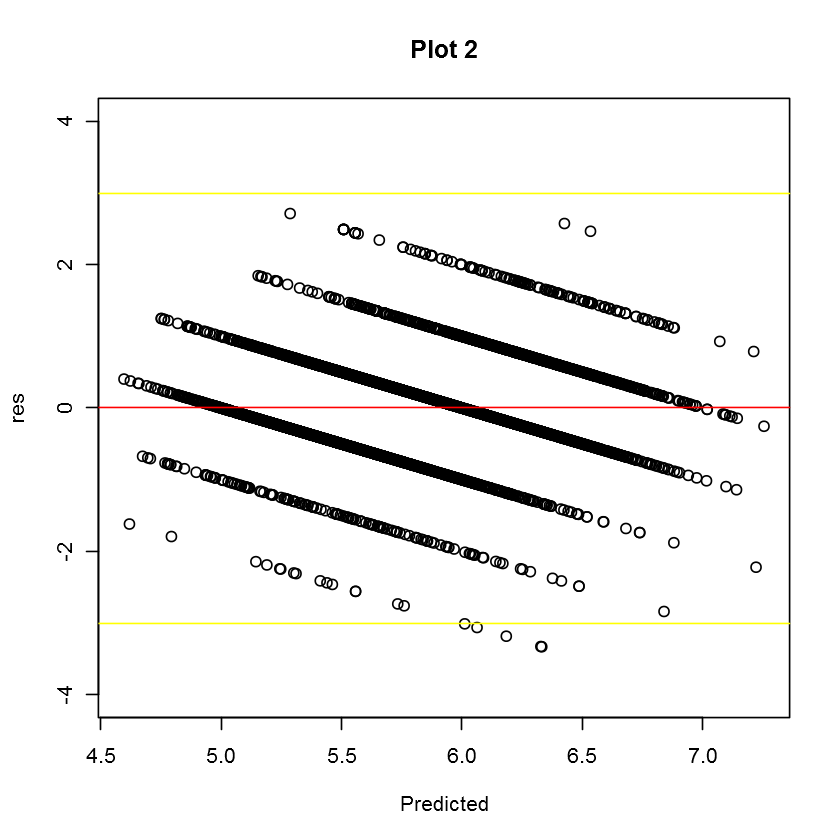

In [34]:
#Graphic appraisal
res= residuals(model)

## Plots 1 and 2
index<-c(1:length(residuals(model)))
plot(index, res, ylim=c(-4,4), main="Plot 1") 
abline(0,0,col="red")
abline(-3,0,col="yellow")
abline(3,0,col="yellow")

Predicted <- predict(model) # Valores predichos
plot(Predicted, res, ylim=c(-4,4), main="Plot 2")
abline(0,0,col="red")
abline(-3,0,col="yellow")
abline(3,0,col="yellow")



Suggested power transformation:  -0.05006369 

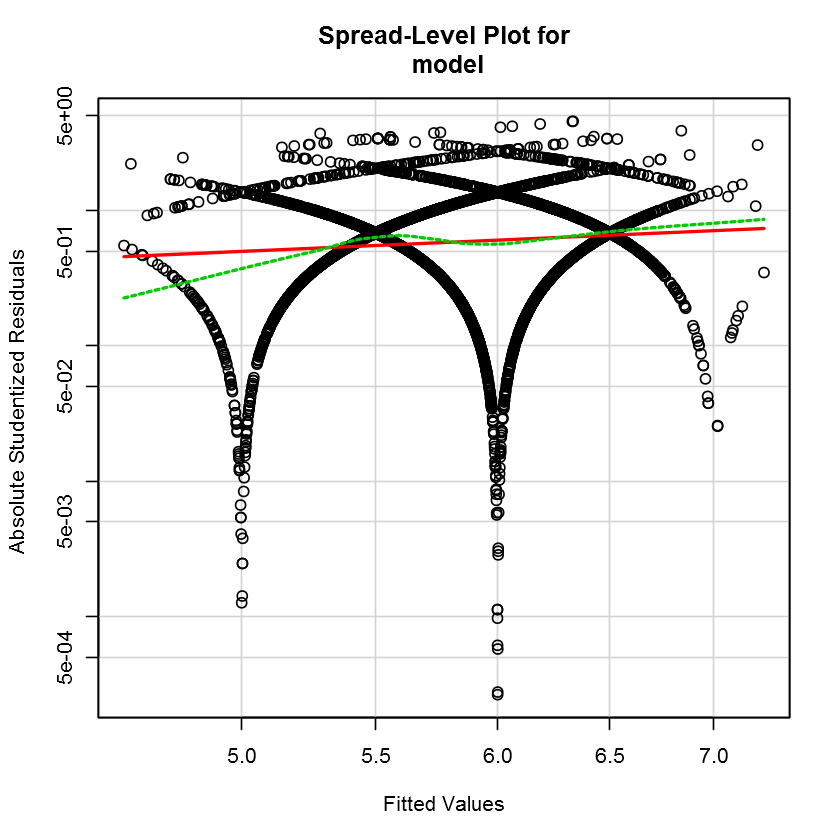

In [49]:
# Plot 3: creates scatter plot of the absolute standardized residuals vs fitted value
spreadLevelPlot(model)

,Test stat,Pr(>|t|)
fixed.acidity,-1.064,0.287
volatile.acidity,2.572,0.010
residual.sugar,-1.941,0.052
chlorides,2.622,0.009
sulphates,1.087,0.277
alcohol,4.207,0.000
type,NA,NA
Tukey test,0.570,0.569


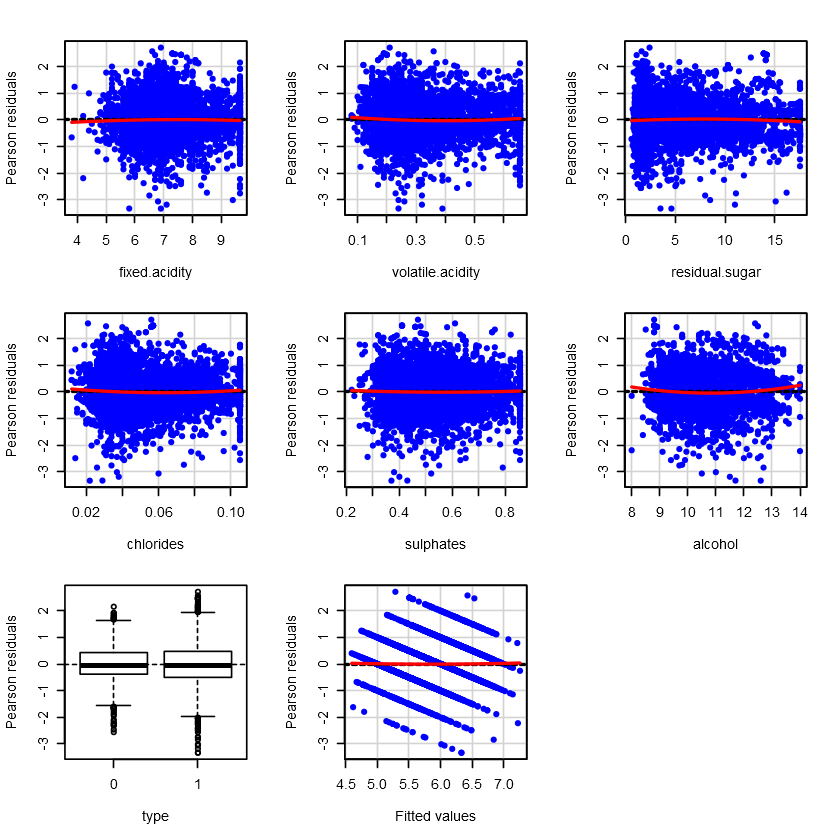

In [22]:
##Plot 4: residualPlots
residualPlots(model, pch=19, col="blue", cex=0.6)

The first graph shows the presence of some outliers (bad news!) values but not a hard homoscedasticity problem. In fact, we can see an almost uniform distribution of the residual points over and below the zero (red line).

The graphics considering the predicted or fitted values on x-axis shows a clear absence of a classification variable on the model.  At this point, we have to remember that the response variable (quality) actually takes only integer values but has been assumed to be continuous.  So, this should be the reason why of the residual pattern.

The last graphs (Plot 4: residualPlots) presents graphics of the residuals (y-axis) v/s  the independent variables (x-axis).  Here it is observed that even though the relationship of y with the variable xj is linear, the model is heteroscedastic and the cause of this problem can be the explanatory variable xj, except perhaps the alcohol variable. Great!  It appears that we find one of the the root of the problem. The solution should be transforming the model taking into account this fact.


In [58]:
#Appreciation with statistical hypothesis test
# Ho: We have in presence of homoscedasticity (constant variance)

###Test based on the function ncvTest() from car package
ncvTest(model)


Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 31.72921    Df = 1     p = 1.772364e-08 

The very small p value(1.772364e-08 ) indicates non constant error variance.

To try to stabilize the non-constant error variance, power transformation of -0.05006369 (approximated as
negative square root) is suggested by spread level plot.

Anyway, first we have to consider transforming xj according to what the residual plot (Plot 4) is telling us about.

## How about Independence (not correlated residuals)?


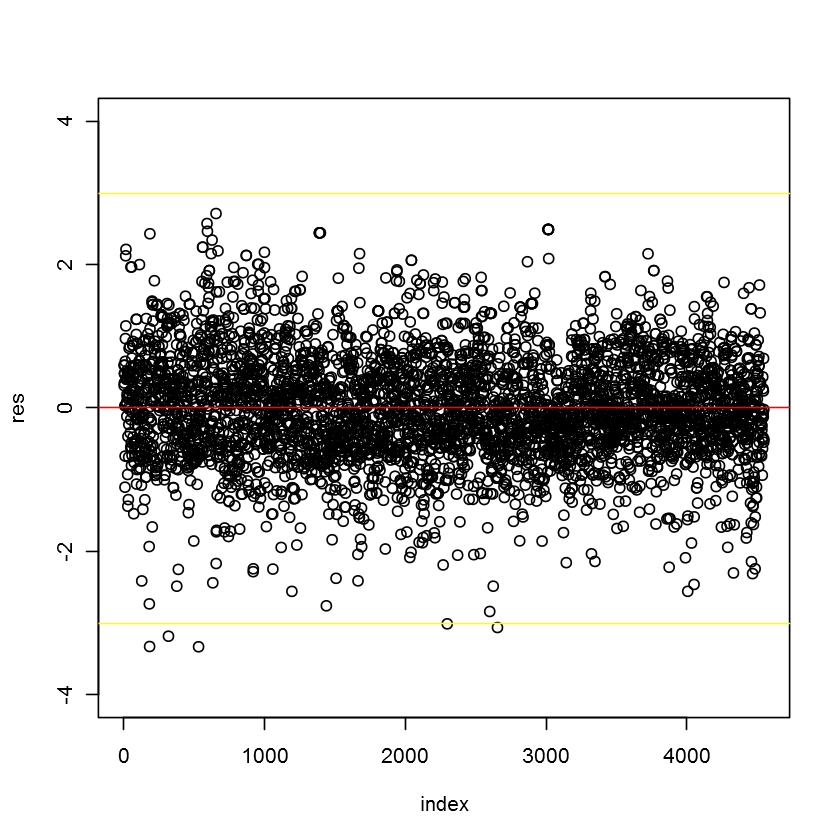

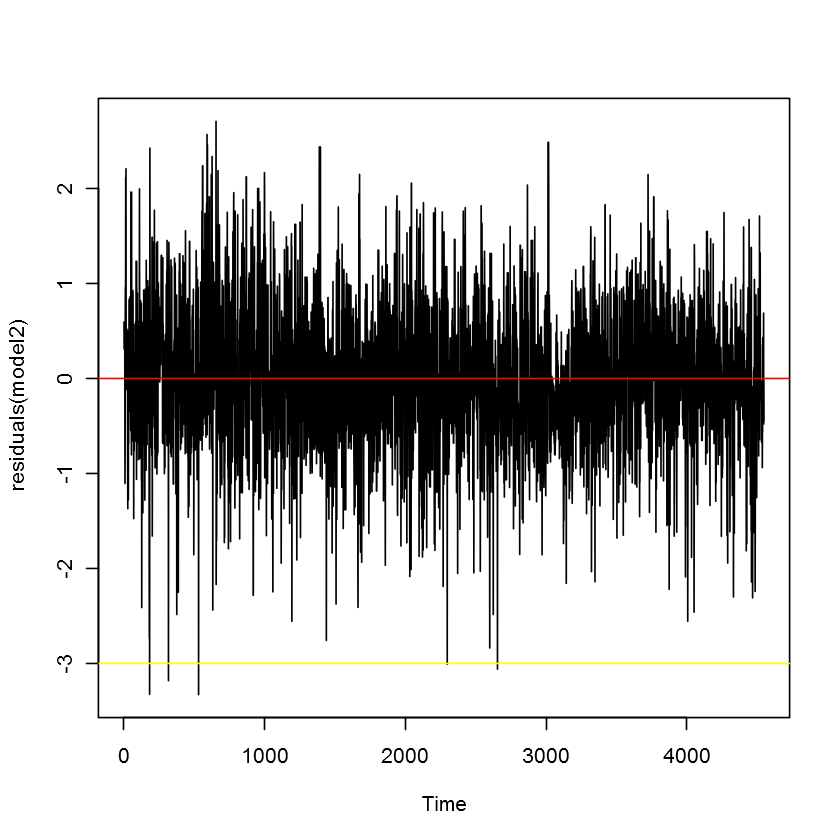

In [17]:
#Graphic appraisal
res= residuals(model)

index<-c(1:length(residuals(model)))
plot(index, res, ylim=c(-4,4)) 
abline(0,0,col="red")
abline(-3,0,col="yellow")
abline(3,0,col="yellow")

ts.plot(residuals(model2))
abline(0,0,col="red")
abline(-3,0,col="yellow")
abline(3,0,col="yellow")


The graphs show the presence of some outliers (bad news!) values but not a clear possible residual dependability problem. In fact, in the first graph, we can see an almost uniform distribution of the residual points over and below the zero (red line). There is not a clear sign of any tendency with what the data trend may be attached.


In [16]:
#Appreciation with statistical hypothesis test
# Ho: We have in presence of independency (not correlated residuals)

###Test based on the function ncvTest() from car package
# Ho: There is not autocorrelation of first order.
durbinWatsonTest(model)


 lag Autocorrelation D-W Statistic p-value
   1       0.1686325      1.662512       0
 Alternative hypothesis: rho != 0

The p-value is smaller (bad news!) than 0.05.  So, the null hypothesis(defined as no autocorrelation) can not be accepted. Thus, the errors should be considered as dependent and the autocorrelation is at least of the first order.

## How about Linearity?

Linearity assumption is checked by using crPlots() function from car package. The component plus
residual plot (Partial residual plot) shows whether the relationships between the dependent and
independent variables are linear. 

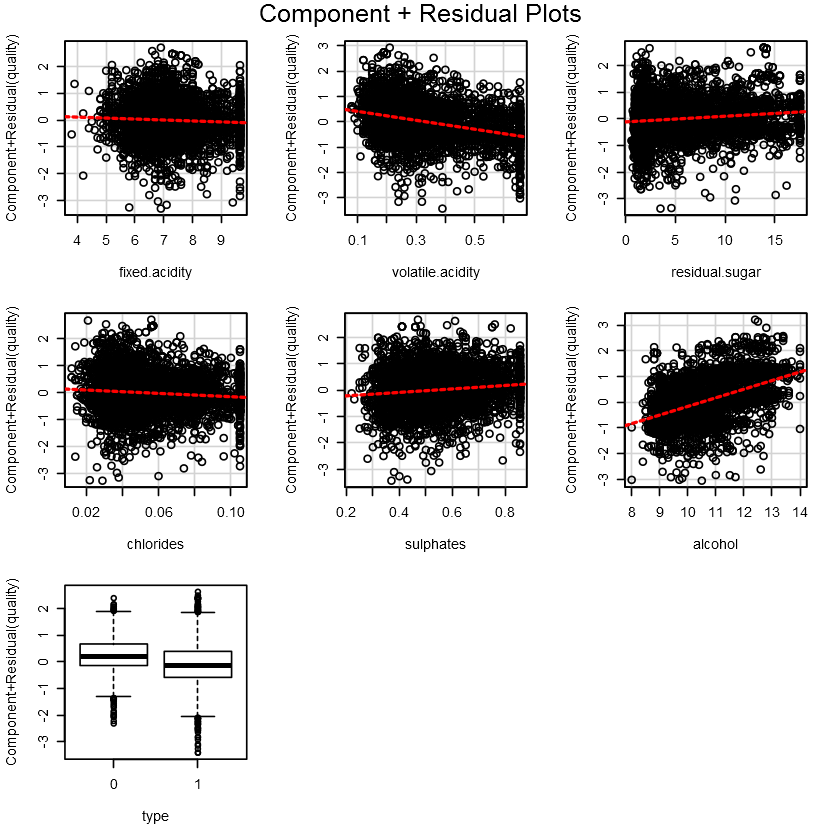

In [19]:
#Graphic appraisal
##crPlots() function from car package. 
crPlots(model, smooth=FALSE)


From the plot shown above, it is not difficult to assume a linear relationship between the independents and dependent variables.  Anyway, it is again clear that the model is heteroscedastic.  The cause of this problem may be the explanatory variable xj, except perhaps the alcohol variable. 

## How about Influencial Observations?

Outliers (having large positive or negative residuals), high leverage (unusual combination of predictor values) and influential observations (influence on parameter estimation) are identified through the following:

* Studentized deleted residuals (a point is outlier if residual is outside of [-3, 3] limits.
* DFITS (a point is outlier if residual is outside of [-1, 1] limits.
* Cook’s distance(Observations are influencial if their Cook's distance is greather than one).

It should be noted that this "rules" can be slightly modified depending on the author.  For instance, a Studentized residuals threshold could be [-2,2] or even [-1,1].

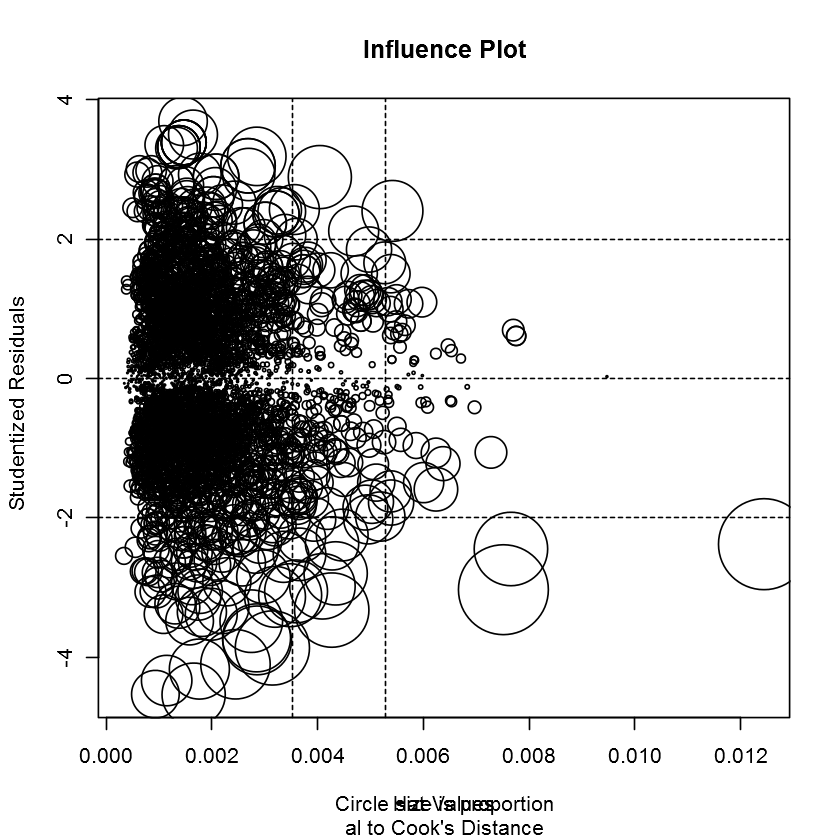

In [33]:
# Plot 1: Influence plot. Outlier, leverage and influential points are plotted together.
influencePlot(model, id.method="identify", main="Influence Plot", sub="Circle size is proportion
al to Cook's Distance")

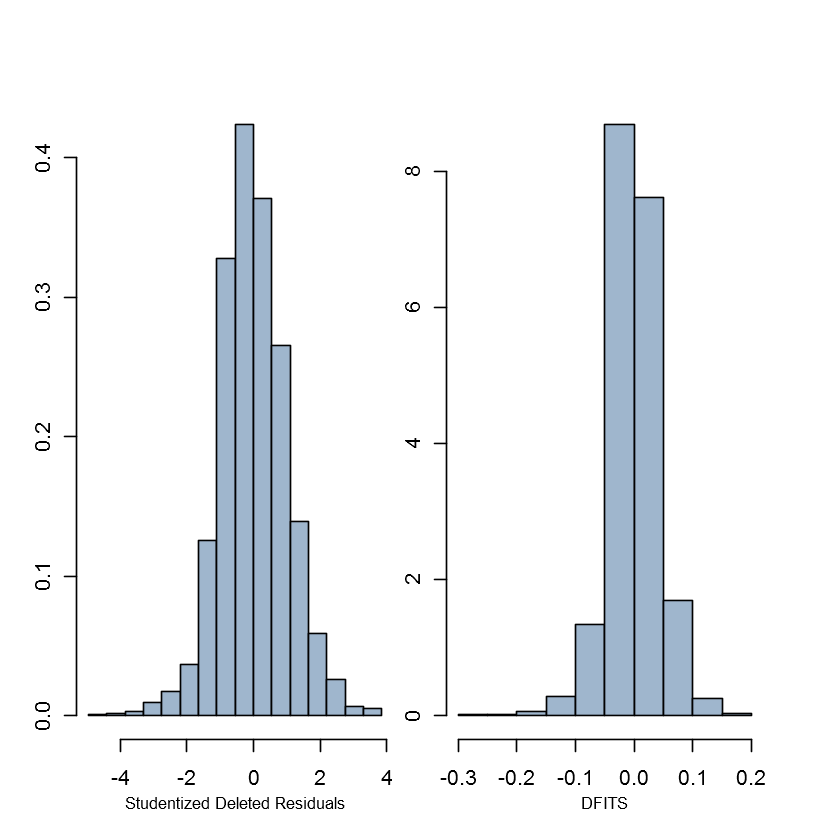

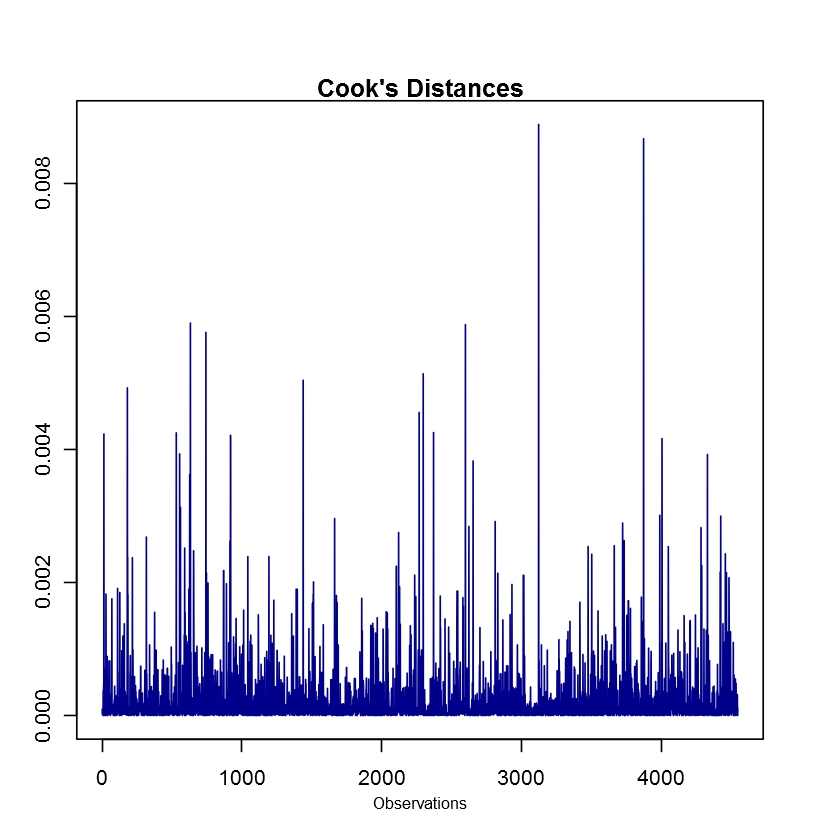

In [40]:
#Plot 2: Studentized deleted residuals, DFITS and Cook's distances
par(mfrow=c(1,2), oma = c(3,2,3,2) + 0.1, mar = c(1,1,1,1) + 0.1)
stddres<-studres(model)
truehist(stddres, h = 0.55, col="slategray3")
mtext("Studentized Deleted Residuals", side=1, line=2, cex=0.8)
d.fit <- dffits(model)
truehist(d.fit, h = 0.05, col="slategray3")
mtext("DFITS", side=1, line=2, cex=0.8)
par(mfrow=c(1,1), oma = c(3,2,3,2) + 0.1, mar = c(1,1,1,1) + 0.1)
cook.d <- cooks.distance(model)
ts.plot(cook.d, col="dark blue", main="Cook's Distances")
mtext("Observations", side=1, line=2, cex=0.8)


From plot 1, observations that have studentized residuals beyond -2 and 2 could be considered outliers. Points to the right of the dotted vertical lines are usually defined as leverage points and points that have large circle size could be considered as influencing observations.

From plot 2, note that no point is identified as an outlier with DFITS value. At the same time, none of the observations should be considered influential as their Cook's distance is less than one.


Finally, R provides the convenience function <i>influence.measures()</i>, which simultaneously calls dffits(), dfbetas(), covratio(), hatvalues(), cooks.distance() functions.  To learn about the cut-off points please refer to the manual. Anyway, it is good to remember that those cut-off values are just suggestive points. It doesn't mean we always need to delete the points which are outside of cut-off points.

In [58]:
summary(influence.measures(model))


Potentially influential observations of
	 lm(formula = quality ~ fixed.acidity + volatile.acidity + residual.sugar +      chlorides + sulphates + alcohol + type, data = dftrain) :

     dfb.1_ dfb.fxd. dfb.vlt. dfb.rsd. dfb.chlr dfb.slph dfb.alch dfb.typ1
21   -0.06   0.00     0.15    -0.03    -0.02    -0.02     0.05     0.07   
23    0.01   0.00    -0.01    -0.05     0.01    -0.01    -0.01     0.03   
24   -0.01   0.01     0.03    -0.01     0.01     0.00    -0.01     0.03   
55    0.00  -0.01    -0.02    -0.03     0.07    -0.02     0.00     0.03   
69    0.00  -0.01    -0.01    -0.04     0.00     0.05    -0.01     0.03   
75    0.00  -0.01    -0.01    -0.04     0.00     0.05    -0.01     0.03   
125   0.00  -0.01    -0.02    -0.01     0.03    -0.01     0.00     0.01   
160   0.01  -0.05     0.05    -0.03     0.00    -0.05     0.03     0.01   
170   0.01  -0.02    -0.01     0.00     0.01     0.01     0.00     0.00   
177   0.07  -0.03    -0.01    -0.02    -0.04     0.04    -0.10    -0.

## How about the Final Model?

Since the base model has a very low Rsquared (0.2801), its predictive capacity is too low to think about improving its structure and use it as a final machine learning model to predict wine quality. Even if we improve its structure, its predictive capacity will still be bad.

It is left to the discretion and decision of the reader to make or not the corrections of homocedasticity, normality and dependence. For my sake, I am an eminently practical person and I will not invest more time in fixing something that I will not use. So things, to continue with this project, I will stay with the model with the problems as they are.

## 43 Model Consolidation

In [24]:
## Control Resampling Technique: 10-fold CV
#fiveStats = function(...) c (twoClassSummary(...), defaultSummary(...))
fiveStats = function(...) c (defaultSummary(...))
cvCtrl <- trainControl(method = "cv", number=10,  summaryFunction = fiveStats, classProbs = FALSE, savePredictions=T)

In [25]:
## Construction Predictive Model
set.seed(7)
formula <- as.formula("quality ~ volatile.acidity + residual.sugar + chlorides + total.sulfur.dioxide + pH + sulphates + alcohol")
mlrmodel <- train(formula, data=dftrain, method="lm",   trControl = cvCtrl, metric="Rsquared")

In [26]:
# Getting summary of fitted model2
summary(mlrmodel)


Call:
lm(formula = .outcome ~ ., data = dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.4468 -0.4592 -0.0417  0.4682  2.7437 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           1.9295104  0.2815898   6.852 8.25e-12 ***
volatile.acidity     -1.5406579  0.0941841 -16.358  < 2e-16 ***
residual.sugar        0.0219277  0.0029314   7.480 8.85e-14 ***
chlorides            -1.4634985  0.7330817  -1.996 0.045954 *  
total.sulfur.dioxide -0.0009527  0.0002605  -3.657 0.000258 ***
pH                    0.1819421  0.0750515   2.424 0.015380 *  
sulphates             0.7704683  0.0939626   8.200 3.11e-16 ***
alcohol               0.3317706  0.0114870  28.882  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.7389 on 4541 degrees of freedom
Multiple R-squared:  0.2821,	Adjusted R-squared:  0.281 
F-statistic: 254.9 on 7 and 4541 DF,  p-value: < 2.2e-16


In [27]:
## train results model2
mlrmodel

Linear Regression 

4549 samples
   7 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 4093, 4094, 4095, 4093, 4095, 4095, ... 
Resampling results:

  RMSE       Rsquared 
  0.7394019  0.2800618

Tuning parameter 'intercept' was held constant at a value of TRUE

In [39]:
## Predicting  results mlrmodel on dftest dataset
mlrPred.dftest<-predict(mlrmodel,dftest)
head(mlrPred.dftest,10)


1        3        4       11       12       14       18       20 
5.482670 5.766863 5.672575 6.393730 5.710012 6.673944 5.985814 5.548173 
      37       38 
5.407338 5.739412

In [40]:
## metrics on dftest dataset
mlrmodelvalues<-data.frame(obs = dftest$quality, pred=mlrPred.dftest)
defaultSummary(mlrmodelvalues)


RMSE  Rsquared 
0.7453196 0.2788723

In [30]:
# variable importance mlrmodel
mlr.imp = varImp (mlrmodel , scale = F )
mlr.imp 

lm variable importance

                     Overall
alcohol               28.882
volatile.acidity      16.358
sulphates              8.200
residual.sugar         7.480
total.sulfur.dioxide   3.657
pH                     2.424
chlorides              1.996

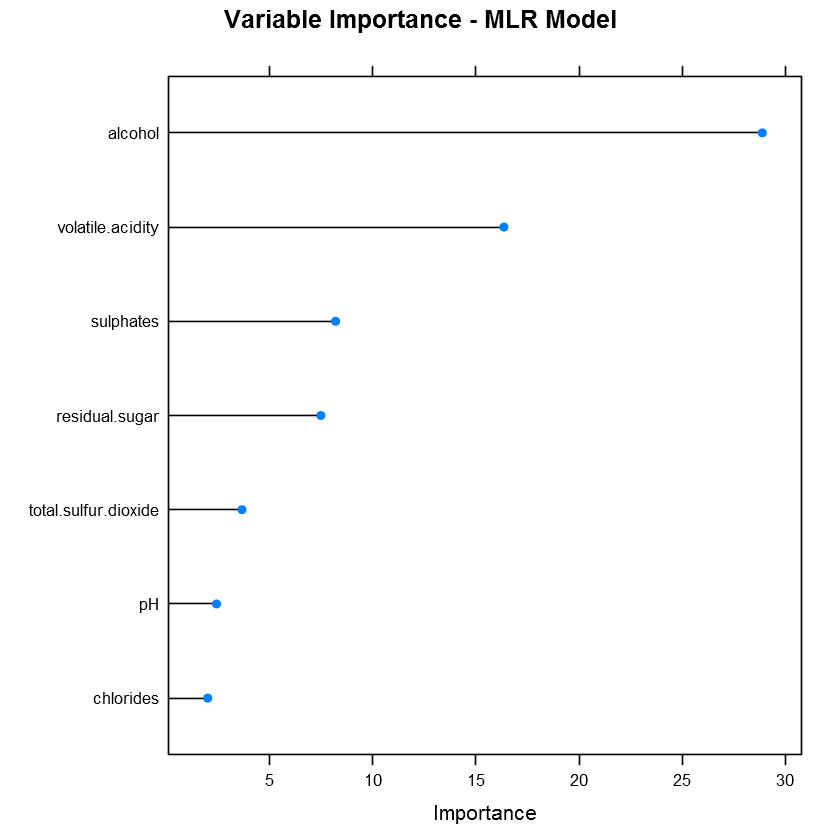

In [31]:
## Graphic variable importance model2
# dev.new()
plot(mlr.imp, top=7, main="Variable Importance - MLR Model")

## V Making predictions

### 51 Predictions mlr model on training dataset

In [51]:
mlrPred.dftrain<-predict(mlrmodel,dftrain)
quality.est<-mlrPred.dftrain
out <- cbind(dftrain, quality.est)
head(out)


,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,total.sulfur.dioxide,pH,sulphates,alcohol,quality,type,quality.est
2,6.3,0.30,0.34,1.60,0.049,132,3.30,0.49,9.5,6,1,5.434691
5,7.2,0.23,0.32,8.50,0.058,186,3.19,0.40,9.9,6,1,5.672575
6,8.1,0.28,0.40,6.90,0.050,97,3.26,0.44,10.1,6,1,5.766863
7,6.2,0.32,0.16,7.00,0.045,136,3.18,0.47,9.6,6,1,5.520266
8,7.0,0.27,0.36,17.55,0.045,170,3.00,0.45,8.8,6,1,5.482670
9,6.3,0.30,0.34,1.60,0.049,132,3.30,0.49,9.5,6,1,5.434691


In [75]:
## Getting data to make plot -quality v/s quality estimated-
plot.fit.train<-data.frame(dftrain$quality, mlrPred.dftrain)

head(plot.fit.train)

,dftrain.quality,mlrPred.dftrain
2,6,5.434691
5,6,5.672575
6,6,5.766863
7,6,5.520266
8,6,5.482670
9,6,5.434691


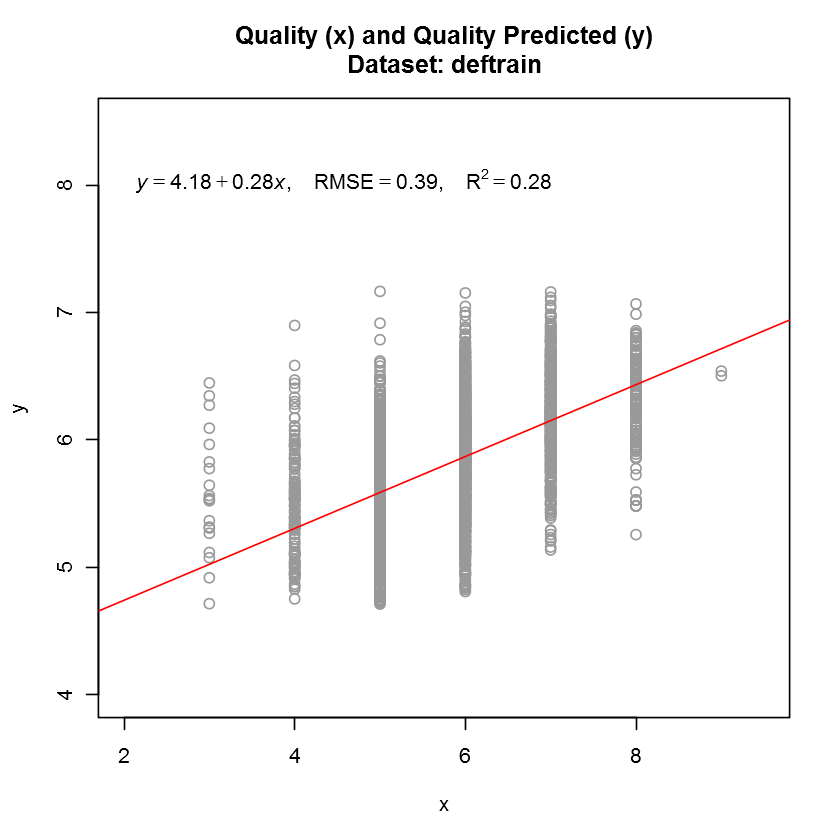

In [120]:
## Creating plot quality v/s quality estimated
x<-dftrain$quality
y<-mlrPred.dftrain
fit <- lm(y ~ x, data = plot.fit.train)


## Calculate RMSE and other values
rmse <- round(sqrt(mean(resid(fit)^2)), 2)
coefs <- coef(fit)
b0 <- round(coefs[1], 2)
b1 <- round(coefs[2],2)
r2 <- round(summary(fit)$r.squared, 2)

eqn <- bquote(italic(y) == .(b0) + .(b1)*italic(x) * ",  " ~~ 
                RMSE == .(rmse)* ",  " ~~ R^2 == .(r2))

## Plotting
plot( x, y, main= "Quality (x) and Quality Predicted (y)\nDataset: deftrain", col="gray60", xlim=c(2,9.5), ylim=c(4,8.5))
abline(fit, col = "red")
text(2, 8, eqn, pos = 4)


### 52 Predictions mlr model on testing dataset

In [53]:
mlrPred.dftest<-predict(mlrmodel,dftest)
quality.est<-mlrPred.dftest
out <- cbind(dftest, quality.est)
head(out)

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,total.sulfur.dioxide,pH,sulphates,alcohol,quality,type,quality.est
1,7.0,0.27,0.36,17.55,0.045,170,3.00,0.45,8.8,6,1,5.482670
3,8.1,0.28,0.40,6.90,0.050,97,3.26,0.44,10.1,6,1,5.766863
4,7.2,0.23,0.32,8.50,0.058,186,3.19,0.40,9.9,6,1,5.672575
11,8.1,0.27,0.41,1.45,0.033,63,2.99,0.56,12.0,5,1,6.393730
12,8.6,0.23,0.40,4.20,0.035,109,3.14,0.53,9.7,5,1,5.710012
14,6.6,0.16,0.40,1.50,0.044,143,3.54,0.52,12.4,7,1,6.673944


In [121]:
## Getting data to make plot -quality v/s quality estimated-
plot.fit.test<-data.frame(dftest$quality, mlrPred.dftest)

head(plot.fit.test)

,dftest.quality,mlrPred.dftest
1,6,5.482670
3,6,5.766863
4,6,5.672575
11,5,6.393730
12,5,5.710012
14,7,6.673944


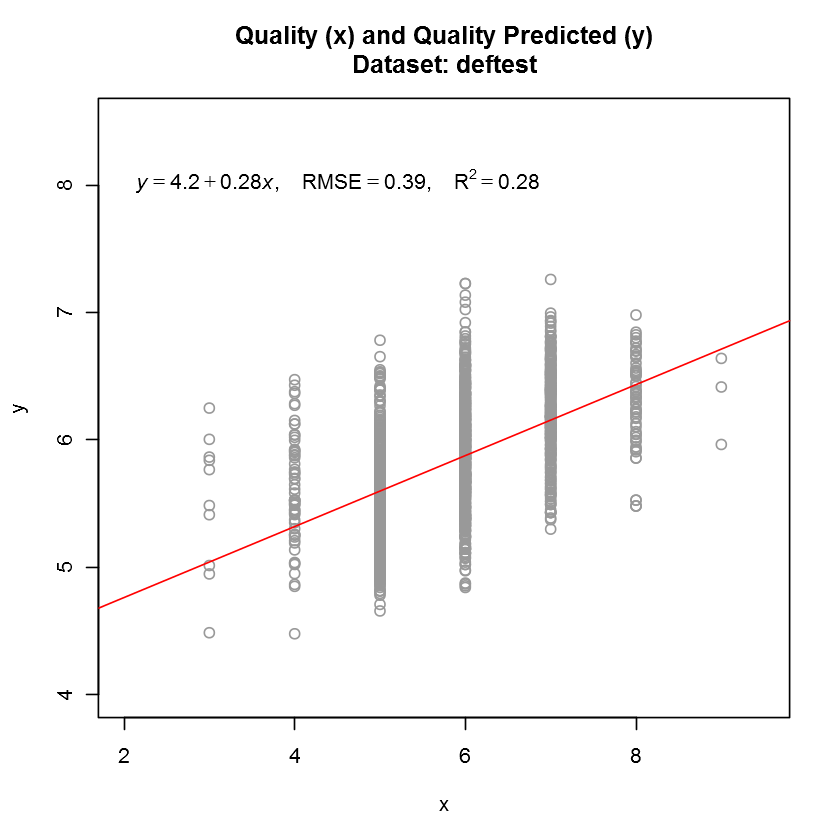

In [123]:
## Creating plot quality v/s quality estimated
x<-dftest$quality
y<-mlrPred.dftest
fit2 <- lm(y ~ x, data = plot.fit.test)


## Calculate RMSE and other values
rmse <- round(sqrt(mean(resid(fit2)^2)), 2)
coefs <- coef(fit2)
b0 <- round(coefs[1], 2)
b1 <- round(coefs[2],2)
r2 <- round(summary(fit2)$r.squared, 2)

eqn <- bquote(italic(y) == .(b0) + .(b1)*italic(x) * ",  " ~~ 
                RMSE == .(rmse)* ",  " ~~ R^2 == .(r2))

## Plotting
plot( x, y, main= "Quality (x) and Quality Predicted (y)\nDataset: deftest", col="gray60", xlim=c(2,9.5), ylim=c(4,8.5))
abline(fit2, col = "red")
text(2, 8, eqn, pos = 4)

### 53 Predictions mlr model on new data

In [72]:
#create new data
sc=matrix(c(0.28, 6.90, 0.050, 97, 3.26, 0.44, 10.1, 	
0.16, 1.50, 0.044, 143, 3.54, 0.52, 12.4, 
0.27, 1.45, 0.033, 63, 2.99, 0.56, 12.0),
byrow=TRUE, ncol=7)
head(sc)

0.28,6.90,0.050,97,3.26,0.44,10.1
0.16,1.50,0.044,143,3.54,0.52,12.4
0.27,1.45,0.033,63,2.99,0.56,12.0


In [74]:
# compute new data  predictions
newdata=matrix(c(sc[1,1], sc[1,2],sc[1,3],sc[1,4],sc[1,5],sc[1,6], sc[1,7],
sc[2,1], sc[2,2],sc[2,3],sc[2,4],sc[2,5],sc[2,6], sc[2,7],
sc[3,1], sc[3,2],sc[3,3],sc[3,4],sc[3,5],sc[3,6], sc[3,7]),
byrow=TRUE, ncol=7)
dimnames(newdata) <- list(NULL, c("volatile.acidity", "residual.sugar", "chlorides", "total.sulfur.dioxide", "pH", "sulphates", "alcohol"))
mlrPred.newdata<-predict(mlrmodel,newdata)
mlrPred.newdata


1        2        3 
5.766863 6.673944 6.393730

Now if you want use another way to get the predictions from a new test data, you can try for instance something similar to what I do in the item 7.4 of my project [MACHINE LEARNING: A comparison of supervised learning algorithms applied to the classification problem with caret R-project library](http://nbviewer.jupyter.org/github/arqmain/Machine_Learning/blob/master/R_MLearning/MLearning_Classification_Comparison_R_Caret/MLearning_Classification_Comparison_R_Caret.ipynb). 

## VI Conclusion

The basic model was gotten selecting the variables included by using the "stepwise backward elimination" based on AIC and BIC selection criterion, and "all Subsets Regression" methods. Anyway, this is modeling so, we may improve more or not the model by filtering other variables, incorporating variable's interactions or using another variable's selection method.

We check the performance of our model by using k-fold cross-validation and it achieved poor predictive metrics, reaching measurements of Rsquared = 0.2800618 and RMSE = 0.7394019. That is, it does not look like wine quality can be predicted in a good way by using an MLR model whatsoever. In other words, wine quality appear not being well supported by its chemical properties in a linear way.

Since the base model has a very low Rsquared (0.2801), its predictive capacity is too low to think about improving its structure and use it as a final machine learning model to predict wine quality. Even if we improve its structure, its predictive capacity will still be bad.

It is left to the discretion and decision of the reader to make or not the corrections of homocedasticity, normality and dependence. For my sake, I am an eminently practical person and I will not invest more time in fixing something that I will not use. 

Finally, it remains to be done to try to model the type of wine separately with MLR. That is, one MLR model for white wine and another for red wine. I leave it up to the reader to do this and compare the results with the joint model discussed in this project. 

<hr>
By: Hector Alvaro Rojas | Data Science, Visualizations and Applied Statistics | October 30, 2017<br>
Url: [http://www.arqmain.net]   &nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;   GitHub: [https://github.com/arqmain]